In [365]:
!pip install emcee
!pip install corner

In [366]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, brentq
import scipy.optimize as opt
import emcee
import math
from scipy.special import gammaln
import corner
import copy

40000
40000
40000
3740


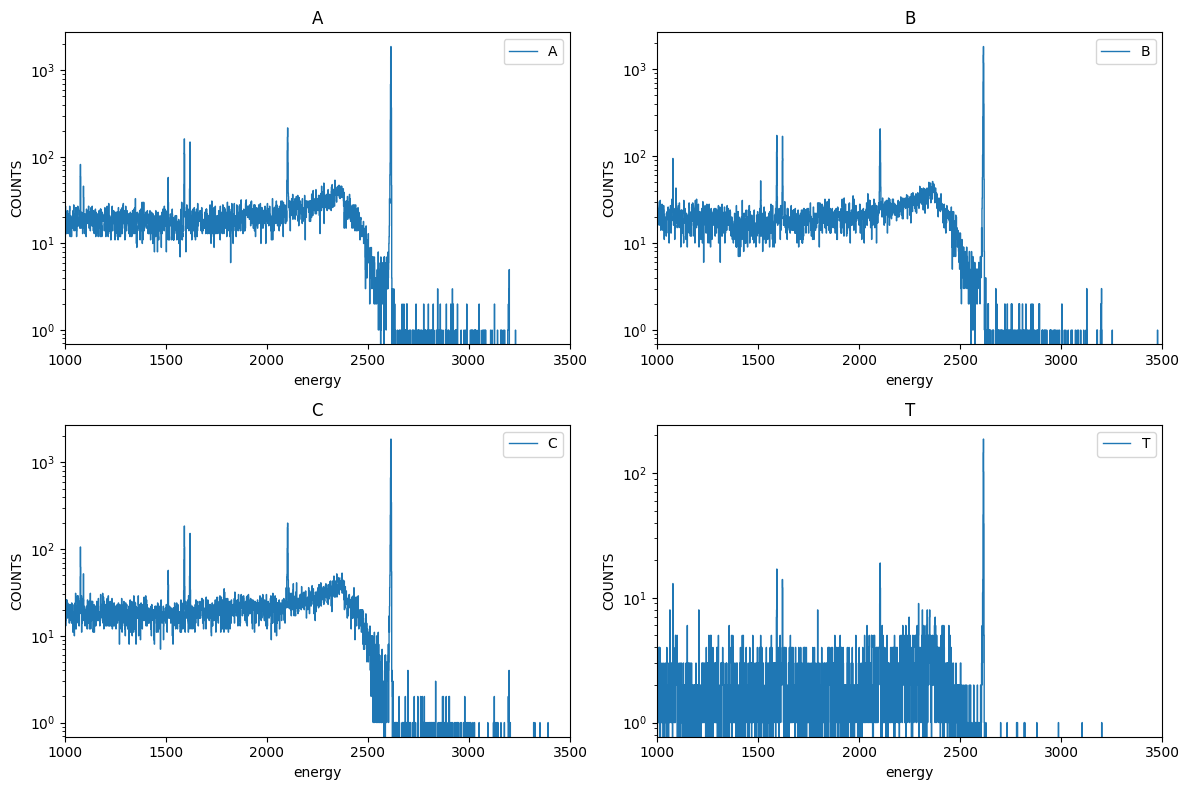

In [367]:
dfA = pd.read_csv("DetectorA.csv")
dfB = pd.read_csv("DetectorB.csv")
dfC = pd.read_csv("DetectorC.csv")
dfTarget = pd.read_csv("DetectorTarget.csv")

print(len(dfA))
print(len(dfB))
print(len(dfC))
print(len(dfTarget))

energy_min, energy_max, bin_width = 1000, 3500, 1
bins = np.arange(energy_min, energy_max + bin_width, bin_width)

hist_A, _ = np.histogram(dfA["energy"], bins=bins)
hist_B, _ = np.histogram(dfB["energy"], bins=bins)
hist_C, _ = np.histogram(dfC["energy"], bins=bins)
hist_Target, _ = np.histogram(dfTarget["energy"], bins=bins)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].stairs(hist_A, bins, label='A', fill=False)
axes[0, 0].set_title('A')
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlabel("energy")
axes[0, 0].set_ylabel("COUNTS")

axes[0, 1].stairs(hist_B, bins, label='B', fill=False)
axes[0, 1].set_title('B')
axes[0, 1].set_yscale('log')
axes[0, 1].set_xlabel("energy")
axes[0, 1].set_ylabel("COUNTS")

axes[1, 0].stairs(hist_C, bins, label='C', fill=False)
axes[1, 0].set_title('C')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel("energy")
axes[1, 0].set_ylabel("COUNTS")

axes[1, 1].stairs(hist_Target, bins, label='T', fill=False)
axes[1, 1].set_title('T')
axes[1, 1].set_yscale('log')
axes[1, 1].set_xlabel("energy")
axes[1, 1].set_ylabel("COUNTS")




for ax in axes.flatten():
  ax.set_xlim(energy_min, energy_max)
  ax.legend()

plt.tight_layout()
plt.show()



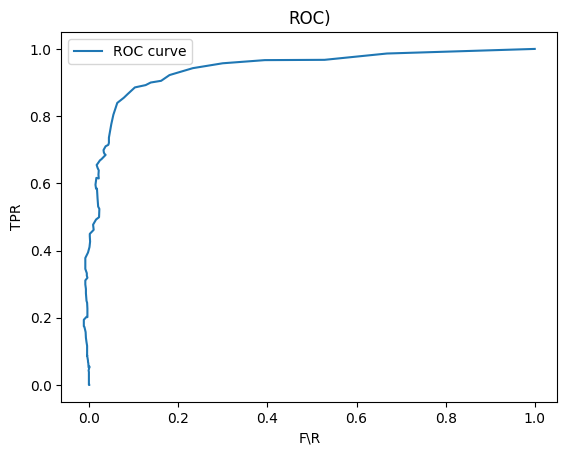

In [368]:
#
#
#
ss_peak_low, ss_peak_high = 1591, 1593
ss_sb_left_low, ss_sb_left_high = 1585, 1590
ss_sb_right_low, ss_sb_right_high = 1595, 1600

ms_peak_low, ms_peak_high = 2102, 2104
ms_sb_left_low, ms_sb_left_high = 2096, 2101
ms_sb_right_low, ms_sb_right_high = 2105, 2110
#
#
#




def metrics(threshold):
  dfA_peak = dfA[(dfA["energy"] >= ss_peak_low) & (dfA["energy"] <= ss_peak_high)]
  dfA_sb_left = dfA[(dfA["energy"] >= ss_sb_left_low) & (dfA["energy"] < ss_sb_left_high)]
  dfA_sb_right = dfA[(dfA["energy"] >= ss_sb_right_low) & (dfA["energy"] < ss_sb_right_high)]
  dfA_sideband = pd.concat([dfA_sb_left, dfA_sb_right])


  peak_counts_A = len(dfA_peak)
  sb_counts_A = len(dfA_sideband)
  ss_peak_width = (ss_peak_high - ss_peak_low)
  ss_sideband_width = ((ss_sb_left_high - ss_sb_left_low)
                         + (ss_sb_right_high - ss_sb_right_low))

  bg_in_peak_A = sb_counts_A / ss_sideband_width * ss_peak_width
  net_peak_A = peak_counts_A - bg_in_peak_A

  dfA_peak_cut = dfA_peak[dfA_peak["cnn_score"] >= threshold]
  dfA_sideband_cut = dfA_sideband[dfA_sideband["cnn_score"] >= threshold]

  peak_cut_A = len(dfA_peak_cut)
  sb_cut_A = len(dfA_sideband_cut)
  bg_in_peak_cut_A = sb_cut_A / ss_sideband_width * ss_peak_width
  net_peak_cut_A = peak_cut_A - bg_in_peak_cut_A

  if net_peak_A > 0:
    TPR = net_peak_cut_A / net_peak_A
  else:
    TPR = 0

  dfB_peak = dfB[(dfB["energy"] >= ms_peak_low) & (dfB["energy"] <= ms_peak_high)]
  dfB_sb_left = dfB[(dfB["energy"] >= ms_sb_left_low) & (dfB["energy"] < ms_sb_left_high)]
  dfB_sb_right = dfB[(dfB["energy"] >= ms_sb_right_low) & (dfB["energy"] < ms_sb_right_high)]
  dfB_sideband = pd.concat([dfB_sb_left, dfB_sb_right])

  peak_counts_B = len(dfB_peak)
  sb_counts_B = len(dfB_sideband)

  ms_peak_width = (ms_peak_high - ms_peak_low)
  ms_sideband_width = ((ms_sb_left_high - ms_sb_left_low)+ (ms_sb_right_high - ms_sb_right_low))

  bg_in_peak_B = sb_counts_B / ms_sideband_width * ms_peak_width
  net_peak_B = peak_counts_B - bg_in_peak_B

  dfB_peak_cut = dfB_peak[dfB_peak["cnn_score"] >= threshold]
  dfB_sideband_cut = dfB_sideband[dfB_sideband["cnn_score"] >= threshold]

  peak_cut_B = len(dfB_peak_cut)
  sb_cut_B = len(dfB_sideband_cut)
  bg_in_peak_cut_B = sb_cut_B / ms_sideband_width * ms_peak_width
  net_peak_cut_B = peak_cut_B - bg_in_peak_cut_B


  if net_peak_B > 0:
    FPR = net_peak_cut_B / net_peak_B
  else:
    FPR = 0

  return TPR, FPR
def roc(n=50):
  thresholds = np.linspace(0,1,n)
  tpr_list = []
  fpr_list = []
  for thr in thresholds:
    tpr_val, fpr_val = metrics(thr)
    tpr_list.append(tpr_val)
    fpr_list.append(fpr_val)
  return thresholds, tpr_list, fpr_list


ts, TPRs, FPRs = roc(n=100)
plt.figure()
plt.plot(FPRs, TPRs, label='ROC curve')
plt.xlabel("F\R")
plt.ylabel("TPR")
plt.title("ROC)")
plt.legend()
plt.show()

In [369]:
import ipywidgets as widgets
from IPython.display import display

def update_threshold(threshold):
  tpr_val, fpr_val = metrics(threshold)
  print(f"Threshold = {threshold:.3f},  TPR = {tpr_val:.3f},  FPR = {fpr_val:.3f}")


threshold_slider = widgets.FloatSlider(min=0.001, max=1.0, step=0.001, value=0.001) #use keyboard for 0.001 movement


widgets.interact(update_threshold, threshold=threshold_slider)

interactive(children=(FloatSlider(value=0.001, description='threshold', max=1.0, min=0.001, step=0.001), Outpu…

<function __main__.update_threshold(threshold)>

In [370]:
thr = 0.104
tpr_val, fpr_val = metrics(thr)
print(tpr_val,fpr_val)

0.8811965811965812 0.09584450402144773


In [371]:
def generate_nldbd_pdf(bins, mu, sigma):
  bin_centers = (bins[:-1] + bins[1:]) / 2.0
  pdf_nldbd = np.exp(-0.5 * ((bin_centers - mu)/sigma)**2)
  norm_factor = np.sum(pdf_nldbd)
  pdf_nldbd /= norm_factor
  return pdf_nldbd

pdf_N = generate_nldbd_pdf(bins, mu=2039, sigma=1)

print("NLDBD PDF sum:", pdf_N.sum())

NLDBD PDF sum: 1.0


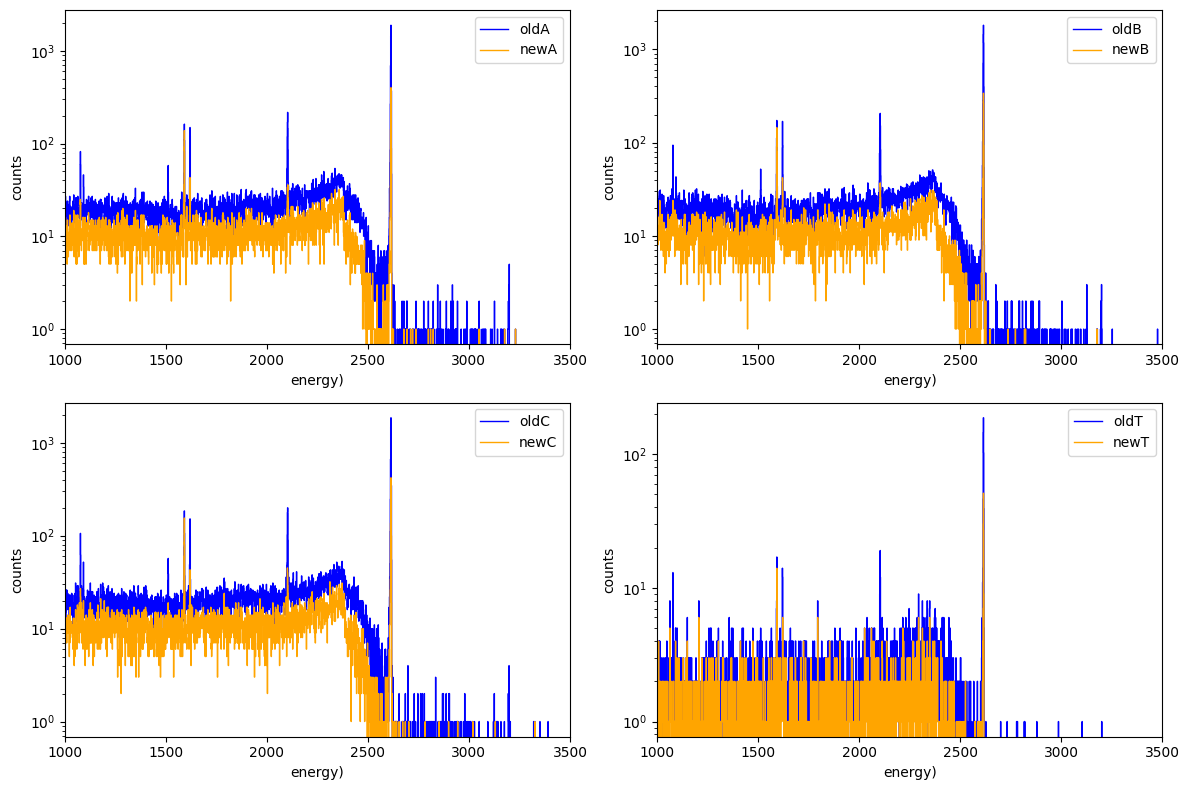

In [372]:
def plot_hist_comparison(dfA, dfB, dfC, dfT, bins, threshold=thr):
  dfA_cut = dfA[dfA['cnn_score'] > threshold]
  dfB_cut = dfB[dfB['cnn_score'] > threshold]
  dfC_cut = dfC[dfC['cnn_score'] > threshold]
  dfT_cut = dfT[dfT['cnn_score'] > threshold]

  histA, _ = np.histogram(dfA["energy"], bins=bins)
  histB, _ = np.histogram(dfB["energy"], bins=bins)
  histC, _ = np.histogram(dfC["energy"], bins=bins)
  histT, _ = np.histogram(dfT["energy"], bins=bins)

  histA_cut, _ = np.histogram(dfA_cut["energy"], bins=bins)
  histB_cut, _ = np.histogram(dfB_cut["energy"], bins=bins)
  histC_cut, _ = np.histogram(dfC_cut["energy"], bins=bins)
  histT_cut, _ = np.histogram(dfT_cut["energy"], bins=bins)

  fig, axes = plt.subplots(2, 2, figsize=(12, 8))


  axes[0, 0].stairs(histA, bins, label='oldA', color='blue')
  axes[0, 0].stairs(histA_cut, bins, label='newA', color='orange')
  axes[0, 0].set_yscale('log')
  axes[0, 0].set_xlim(1000, 3500)
  axes[0, 0].legend()


  axes[0, 1].stairs(histB, bins, label='oldB', color='blue')
  axes[0, 1].stairs(histB_cut, bins, label='newB', color='orange')
  axes[0, 1].set_yscale('log')
  axes[0, 1].legend()


  axes[1, 0].stairs(histC, bins, label='oldC', color='blue')
  axes[1, 0].stairs(histC_cut, bins, label='newC', color='orange')
  axes[1, 0].set_yscale('log')
  axes[1, 0].legend()


  axes[1, 1].stairs(histT, bins, label='oldT', color='blue')
  axes[1, 1].stairs(histT_cut, bins, label='newT', color='orange')
  axes[1, 1].set_yscale('log')
  axes[1, 1].legend()

  for ax in axes.flatten():
    ax.set_xlabel("energy)")
    ax.set_ylabel("counts")
    ax.set_xlim(bins[0], bins[-1])

  plt.tight_layout()
  plt.show()


plot_hist_comparison(dfA, dfB, dfC, dfTarget, bins, threshold=0.1)

In [373]:
threshold = thr


dfA_cut = dfA[dfA['cnn_score'] >= threshold]
dfB_cut = dfB[dfB['cnn_score'] >= threshold]
dfC_cut = dfC[dfC['cnn_score'] >= threshold]
dfT_cut = dfTarget[dfTarget['cnn_score'] >= threshold] #RL


histA, edgesA = np.histogram(dfA_cut["energy"], bins=bins)
histB, edgesB = np.histogram(dfB_cut["energy"], bins=bins)
histC, edgesC = np.histogram(dfC_cut["energy"], bins=bins)
histT, edgesT = np.histogram(dfT_cut["energy"], bins=bins) #RL


pdfA = histA / histA.sum() if histA.sum() > 0 else histA
pdfB = histB / histB.sum() if histB.sum() > 0 else histB
pdfC = histC / histC.sum() if histC.sum() > 0 else histC
pdfT = histT / histT.sum() if histT.sum() > 0 else histT #RL


bin_centersA = 0.5*(edgesA[:-1] + edgesA[1:])
bin_centersB = 0.5*(edgesB[:-1] + edgesB[1:])
bin_centersC = 0.5*(edgesC[:-1] + edgesC[1:])
bin_centersT = 0.5*(edgesT[:-1] + edgesT[1:]) #RL




print(sum(pdfA))
print(sum(pdfB))
print(sum(pdfC))

1.0000000000000033
1.0000000000000009
0.999999999999997


In [374]:
def log_prior(params):
  thetaA, thetaB, thetaC, thetaN = params
  muA, sigmaA = 1350.0, 100.0
  muB, sigmaB = 770.0, 270.0

  if not (0 <= thetaC <= 1e4):
    return -np.inf
  if not (0 <= thetaN <= 1e3):
    return -np.inf


  lp_A = -0.5*((thetaA - muA)/sigmaA)**2 - np.log(np.sqrt(2*np.pi)*sigmaA)
  lp_B = -0.5*((thetaB - muB)/sigmaB)**2 - np.log(np.sqrt(2*np.pi)*sigmaB)


  return lp_A + lp_B

def log_likelihood(params):
  thetaA, thetaB, thetaC, thetaN = params
  lamb = thetaA*pdfA + thetaB*pdfB + thetaC*pdfC + thetaN*pdf_N

  if np.any(lamb < 0):
    return -np.inf

  n = histT
  term1 = -lamb
  term2 = np.where(n>0, n*np.log(lamb), 0.0)
  term3 = -gammaln(n+1)
  return np.sum(term1 + term2 + term3)

def log_posterior(params):
  lp = log_prior(params)
  if not np.isfinite(lp):
    return -np.inf
  ll = log_likelihood(params)
  return lp + ll

ndim = 4
nwalkers = 50
n_burn = 2000
n_prod = 5000
p0 = []
for i in range(nwalkers):
  p0.append([np.random.normal(1350, 20), np.random.normal(770, 50), np.random.uniform(0, 500), np.random.uniform(0, 100)
    ])
p0 = np.array(p0)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

state = sampler.run_mcmc(p0, n_burn, progress=True)
sampler.reset()

sampler.run_mcmc(state, n_prod, progress=True)

chain = sampler.get_chain(flat=True)


thetaA_samples = chain[:,0]
thetaB_samples = chain[:,1]
thetaC_samples = chain[:,2]
thetaN_samples = chain[:,3]

def median_and_68CI(samples):
  median = np.median(samples)
  bounds = np.percentile(samples, [16, 84])
  return median, bounds[0], bounds[1]

A_med, A_lo, A_hi = median_and_68CI(thetaA_samples)
B_med, B_lo, B_hi = median_and_68CI(thetaB_samples)
C_med, C_lo, C_hi = median_and_68CI(thetaC_samples)
N_med, N_lo, N_hi = median_and_68CI(thetaN_samples)


print(f"  θA = {A_med:.2f}  [16%-84%: {A_lo:.2f}, {A_hi:.2f}]")
print(f"  θB = {B_med:.2f}  [16%-84%: {B_lo:.2f}, {B_hi:.2f}]")
print(f"  θC = {C_med:.2f}  [16%-84%: {C_lo:.2f}, {C_hi:.2f}]")
print(f"  θNLDBD = {N_med:.2f}  [16%-84%: {N_lo:.2f}, {N_hi:.2f}]")

<ipython-input-374-2c8747c5a22a>:27: RuntimeWarning: divide by zero encountered in log
  term2 = np.where(n>0, n*np.log(lamb), 0.0)
<ipython-input-374-2c8747c5a22a>:27: RuntimeWarning: invalid value encountered in multiply
  term2 = np.where(n>0, n*np.log(lamb), 0.0)
100%|██████████| 5000/5000 [00:54<00:00, 91.15it/s] 

  θA = 1031.87  [16%-84%: 957.87, 1106.72]
  θB = 431.92  [16%-84%: 341.64, 521.83]
  θC = 292.27  [16%-84%: 207.90, 381.57]
  θNLDBD = 5.13  [16%-84%: 2.68, 8.34]


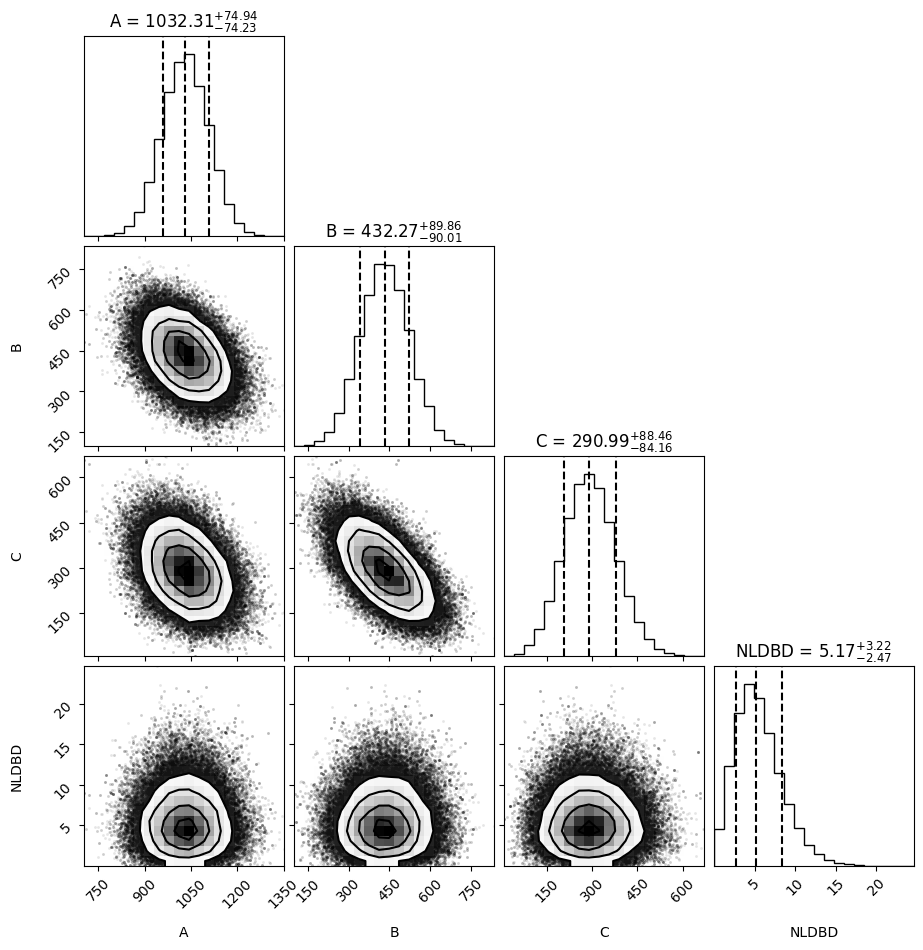

In [375]:
labels = ["A", "B", "C", "NLDBD"]
samples = sampler.get_chain()
nsteps, nwalkers, ndim = samples.shape


burn = 1000
thin = 1
flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)


fig_corner = corner.corner(flat_samples, labels=labels,quantiles=[0.16, 0.5, 0.84],show_titles=True, title_fmt=".2f")
plt.show()

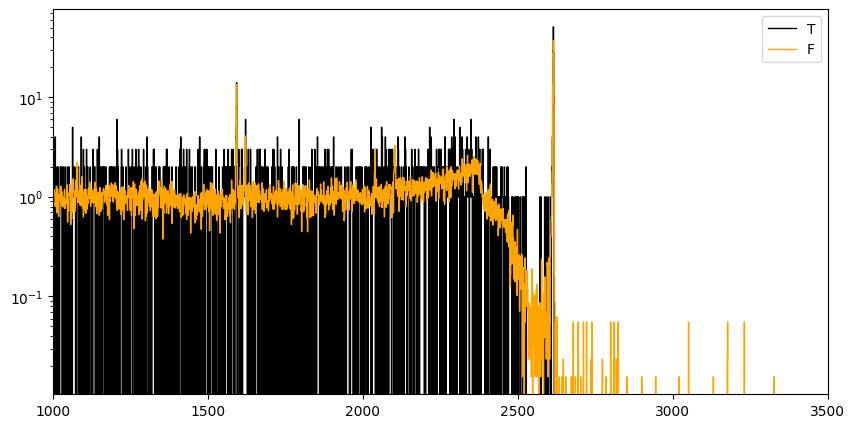

In [382]:
def hypothesis(thetaA, thetaB, thetaC, thetaN):
  modelA = thetaA * pdfA
  modelB = thetaB * pdfB
  modelC = thetaC * pdfC
  modelN = thetaN * pdf_N
  return modelA + modelB + modelC + modelN


thetaA_best = A_med
thetaB_best = B_med
thetaC_best = C_med
thetaN_best = N_med



fitted_hist = hypothesis(thetaA_best, thetaB_best, thetaC_best, thetaN_best)
plt.figure(figsize=(10,5))
plt.stairs(histT, bins, label="T", color="black")
plt.stairs(fitted_hist, bins, label="F", color="orange")
plt.xlim(1000, 3500)
plt.legend()
plt.yscale('log')
plt.show()

In [377]:
upper_limit_90 = np.percentile(thetaN_samples, 90)
print(upper_limit_90)

9.413872159185468


In [378]:
thetaA_best = A_med
thetaB_best = B_med
thetaC_best = C_med


asimov_hist = thetaA_best * pdfA + thetaB_best * pdfB + thetaC_best * pdfC


def hypothesis_asimov(thetaN):
  return (thetaA_best * pdfA) + (thetaB_best * pdfB) + (thetaC_best * pdfC) + (thetaN * pdf_N)

def log_likelihood_asimov(thetaN, asimov_data):
  model = hypothesis_asimov(thetaN)
  if (model < 0).any():
    return -np.inf
  obs = asimov_data


  term1 = -model
  term2 = np.where(obs > 0, obs * np.log(model), 0.0)
  term3 = -gammaln(obs + 1)
  return np.sum(term1 + term2 + term3)

def log_prior_asimov(thetaN):
  if thetaN <= 0:
    return -np.inf
  return -0.5 * np.log(thetaN)

def log_posterior_asimov(thetaN, asimov_data):
  lp = log_prior_asimov(thetaN[0])
  if not np.isfinite(lp):
    return -np.inf
  ll = log_likelihood_asimov(thetaN[0], asimov_data)
  return lp + ll


nwalkers = 50
initial = 0.1 + 0.01 * np.random.randn(nwalkers)
sampler_asimov = emcee.EnsembleSampler(nwalkers, 1, log_posterior_asimov,
                                       args=[asimov_hist])

state = sampler_asimov.run_mcmc(initial[:, None], 2000, progress=True)
sampler_asimov.reset()
sampler_asimov.run_mcmc(state, 5000, progress=True)

<ipython-input-378-b8425becc082>:20: RuntimeWarning: divide by zero encountered in log
  term2 = np.where(obs > 0, obs * np.log(model), 0.0)
<ipython-input-378-b8425becc082>:20: RuntimeWarning: invalid value encountered in multiply
  term2 = np.where(obs > 0, obs * np.log(model), 0.0)
100%|██████████| 5000/5000 [00:42<00:00, 116.37it/s]


State([[1.27561568e-01]
 [7.98078005e-01]
 [3.05316306e+00]
 [2.62528238e-01]
 [3.53857886e+00]
 [3.79331785e-02]
 [4.35169647e+00]
 [5.62866262e-01]
 [2.01112997e-01]
 [6.10935748e+00]
 [2.95592165e-01]
 [2.01331362e+00]
 [4.38354734e-01]
 [5.34836411e-02]
 [7.81308764e-05]
 [2.17278337e+00]
 [4.34847864e-01]
 [1.70761857e-01]
 [9.09451911e-01]
 [6.49691445e-03]
 [1.67312943e-03]
 [4.05535640e+00]
 [1.11233600e+00]
 [8.31474667e-01]
 [6.16716356e-02]
 [1.00190618e-01]
 [1.13779333e-02]
 [5.79295737e-01]
 [5.09952591e+00]
 [2.99774637e-01]
 [3.62276678e-02]
 [6.68068908e+00]
 [3.19635164e+00]
 [9.92349474e-02]
 [1.27197481e-01]
 [4.54167022e-01]
 [9.78068837e-01]
 [1.48288321e-02]
 [9.64696068e-01]
 [3.14075219e-02]
 [1.62988095e-01]
 [3.39094692e+00]
 [1.78327098e+00]
 [3.18277836e+00]
 [5.30011787e-01]
 [1.64663673e-01]
 [4.63004474e+00]
 [3.44017079e+00]
 [1.15626023e-01]
 [1.40732851e+00]], log_prob=[-1561.68804926 -1562.68912759 -1564.15439789 -1562.05696578
 -1564.46161345 -1561.

In [379]:
flat_samples_asimov = sampler_asimov.get_chain(discard=500, flat=True)
thetaN_samples_asimov = flat_samples_asimov[:, 0]
upper_90 = np.percentile(thetaN_samples_asimov, 90)

print(upper_90)

3.17393107048229
